In [253]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy
import cvxpy as cp

rng = np.random.default_rng()

In [412]:
# Duplicate values within features and different number of unique values per feature
n = 10000
X = np.hstack(
    [rng.integers(0, 100, size=(n, 1)) / 10, rng.integers(0, 250, size=(n, 1)) / 250]
)
true_y = 5 + np.sin(X[:, 0]) + np.exp(X[:, 1])
obs_y = true_y + 0.5 * rng.standard_normal(n)

In [413]:
plot_x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
plot_y = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)

x_grid, y_grid = np.meshgrid(plot_x, plot_y)

Z = scipy.interpolate.griddata(
    (X[:, 0], X[:, 1]), true_y, (x_grid, y_grid), method="linear"
)

In [414]:
fig = go.Figure(
    data=[
        go.Surface(x=plot_x, y=plot_y, z=Z),
        go.Scatter3d(
            x=X[:, 0],
            y=X[:, 1],
            z=obs_y,
            opacity=0.1,
            mode="markers",
            marker={"size": 3},
        ),
    ]
)
fig.show()

In [415]:
def make_D_matrix(n):
    ones = np.ones(n)
    return scipy.sparse.spdiags(np.vstack([-ones, ones]), range(2), m=n - 1, n=n)


params = {}

for i in range(X.shape[1]):
    unique_vals, recon_idx = np.unique(X[:, i], return_inverse=True)
    params[i] = {
        "sort_idx": np.argsort(X[:, i]),
        # These are guaranteed to be sorted
        "unique_vals": unique_vals,
        "recon_idx": recon_idx,
        "D_mat": make_D_matrix(len(unique_vals)),
        "beta_vec": cp.Variable(len(unique_vals), name=f"X_{i}"),
    }

In [461]:
# For each observed y value get the relevant beta coefficient for that X observation
# by using the reconstruction index based on the unique values vector
alpha = cp.Variable(name="alpha")
y_hat = alpha + cp.sum(
    [params[i]["beta_vec"][params[i]["recon_idx"]] for i in params.keys()]
)
# y_hat = cp.sum(
#     [params[i]["beta_vec"][params[i]["recon_idx"]] for i in params.keys()]
# )
# Compute separate l1 norms for each input variable and sum
penalty = cp.sum(
    [cp.norm(params[i]["D_mat"] @ params[i]["beta_vec"], 1) for i in params.keys()]
)

lam = 5
# objective = cp.Minimize(0.5 * cp.sum_squares(obs_y - y_hat) + lam * penalty)
objective = cp.Minimize(cp.sum_squares(obs_y - y_hat))
prob = cp.Problem(objective)
results = prob.solve(solver="CLARABEL")

In [462]:
fitted_y = alpha.value + np.sum(
    [params[i]["beta_vec"].value[params[i]["recon_idx"]] for i in params.keys()], axis=0
)
# fitted_y = np.sum(
#     [params[i]["beta_vec"].value[params[i]["recon_idx"]] for i in params.keys()], axis=0
# )

In [463]:
fig = go.Figure(
    data=[
        go.Surface(x=plot_x, y=plot_y, z=Z),
        go.Scatter3d(
            x=X[:, 0],
            y=X[:, 1],
            z=fitted_y,
            opacity=0.1,
            mode="markers",
            marker={"size": 3},
        ),
    ]
)
fig.show()

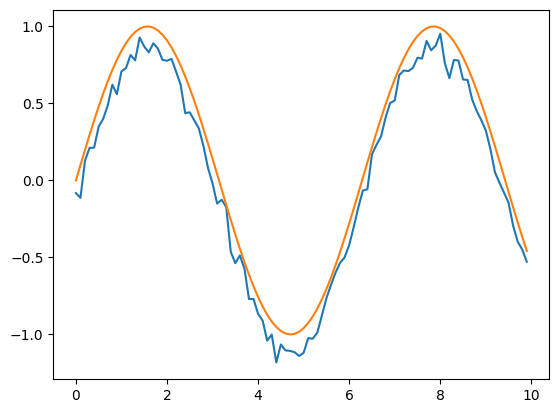

In [464]:
plt.plot(params[0]["unique_vals"], params[0]["beta_vec"].value)
plot_x_0 = np.linspace(
    params[0]["unique_vals"].min(),
    params[0]["unique_vals"].max(),
    len(params[0]["unique_vals"]),
)
plt.plot(
    plot_x_0, np.sin(plot_x_0)
)

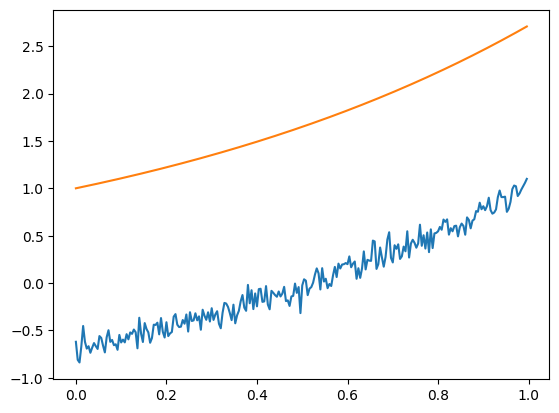

In [465]:
plt.plot(params[1]["unique_vals"], params[1]["beta_vec"].value)
plot_x_1 = np.linspace(
    params[1]["unique_vals"].min(),
    params[1]["unique_vals"].max(),
    len(params[1]["unique_vals"]),
)
plt.plot(
    plot_x_1, np.exp(plot_x_1)
)

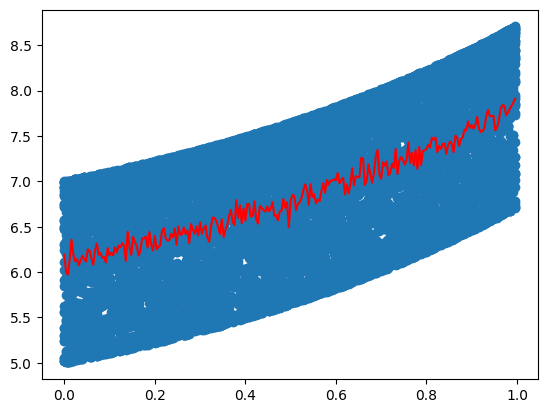

In [466]:
plt.scatter(X[:, 1], true_y)
plt.plot(params[1]["unique_vals"], alpha.value + params[1]["beta_vec"].value, color="red")

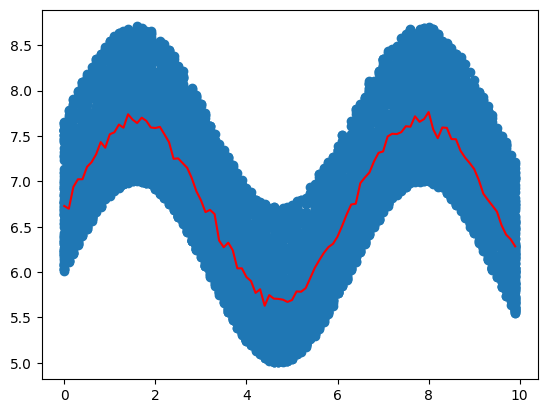

In [467]:
plt.scatter(X[:, 0], true_y)
plt.plot(params[0]["unique_vals"], alpha.value + params[0]["beta_vec"].value, color="red")